In [95]:
%load_ext autoreload
%autoreload 2

In [97]:
import time
import numpy as np
import numpy.linalg as LA
import random
from collections import deque
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
import generate_matrices
from generate_matrices import over_determined, hilbert, rand_for_given_cond_number

In [217]:
def Kaczmarz(A,f,x_0,N_max,eps,reg):
    x = np.copy(x_0)
    m = A.shape[0]
    n = A.shape[1]
    res = [np.linalg.norm(A @ x - f)/np.linalg.norm(f)]
    norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2
    #Kaczmarz method itself
    np.random.seed(666)
    if reg == 0:
        print("no regularization")
        _lambda = np.ones(N_max)
    if reg == 1:
        print("constant regularization")
        _lambda = np.ones(N_max)*(1 + n/m)
    if reg == 2:
        print("random regularization")
        _lambda = 1 + np.random.rand(N_max)
    startTime = time.time()
    for i in range(N_max):
        k = i % m
        x = x + (_lambda[i]*(f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res.append(new_res)
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

In [218]:
def SimpleRandomKaczmarz(A,f,x_0,N_max,eps):
    x = np.copy(x_0)
    m = A.shape[0]
    res = [np.linalg.norm(A @ x - f)/np.linalg.norm(f)]
    norms = np.zeros(m)
    cum_norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2   
    np.random.seed(666)
    #just uniform distribution on the set of equations
    startTime = time.time()
    for i in range(N_max):
        k = np.random.randint(m)
        x = x + ((f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res.append(new_res)
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

In [219]:
def RandomKaczmarz(A,f,x_0,N_max,eps,reg):
    x = np.copy(x_0)
    m = A.shape[0]
    n = A.shape[1]
    res = [np.linalg.norm(A @ x - f)/np.linalg.norm(f)]
    norms = np.zeros(m)
    cum_norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2   
    cum_norms = np.cumsum(norms)
    cum_norms /= cum_norms[len(cum_norms)-1]
    np.random.seed(666)
    if reg == 0:
        print("no regularization")
        _lambda = np.ones(N_max)
    if reg == 1:
        print("constant regularization")
        _lambda = np.ones(N_max)*(1 + n/m)
    if reg == 2:
        print("random regularization")
        _lambda = 1 + np.random.rand(N_max)
    startTime = time.time()
    #Follow Strohmer, Vershinin
    for i in range(N_max):
        r = np.random.rand()
        k = np.searchsorted(cum_norms,r)
        x = x + (_lambda[i]*(f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res.append(new_res)
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

System with matrix from normal distribution

In [164]:
np.random.seed(666)
n = 500
m = 100
A = rand_for_given_cond_number(n,m, cond = 200)
true_vect = np.random.rand(m)
values = A @ true_vect
x_0 = np.random.rand(m)

not full rank
sing_vals: [ 200.          197.98989899  195.97979798  193.96969697  191.95959596
  189.94949495  187.93939394  185.92929293  183.91919192  181.90909091
  179.8989899   177.88888889  175.87878788  173.86868687  171.85858586
  169.84848485  167.83838384  165.82828283  163.81818182  161.80808081
  159.7979798   157.78787879  155.77777778  153.76767677  151.75757576
  149.74747475  147.73737374  145.72727273  143.71717172  141.70707071
  139.6969697   137.68686869  135.67676768  133.66666667  131.65656566
  129.64646465  127.63636364  125.62626263  123.61616162  121.60606061
  119.5959596   117.58585859  115.57575758  113.56565657  111.55555556
  109.54545455  107.53535354  105.52525253  103.51515152  101.50505051
   99.49494949   97.48484848   95.47474747   93.46464646   91.45454545
   89.44444444   87.43434343   85.42424242   83.41414141   81.4040404
   79.39393939   77.38383838   75.37373737   73.36363636   71.35353535
   69.34343434   67.33333333   65.32323232   63.31313

Test regularization impact here

In [165]:
eps = 1e-10
N_max = 50000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg = 0)
x_RegCar,res_RegCar,t_RegCar = Kaczmarz(A,values,x_0,N_max,eps, reg = 1)
x_RandRegCar,res_RandRegCar,t_RandRegCar = Kaczmarz(A,values,x_0,N_max,eps, reg = 2)

no regularization
constant regularization
random regularization


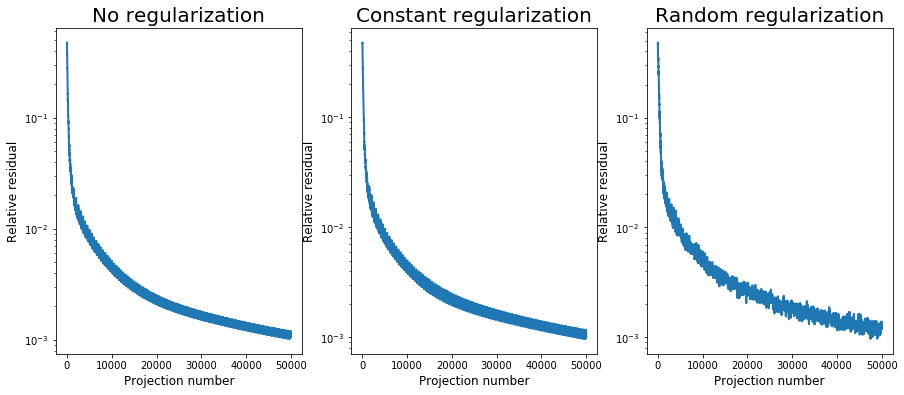

In [166]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.plot(res_Car, linestyle = '-', linewidth = 2.0)
plt.title('No regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.subplot(132)
plt.plot(res_RegCar, linestyle = '-', linewidth = 2.0, label='Regularized Kaczmarz')
plt.title('Constant regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.subplot(133)
plt.plot(res_RandRegCar, linestyle = '-', linewidth = 2.0, label='Randomly regularized Kaczmarz')
plt.title('Random regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.show()

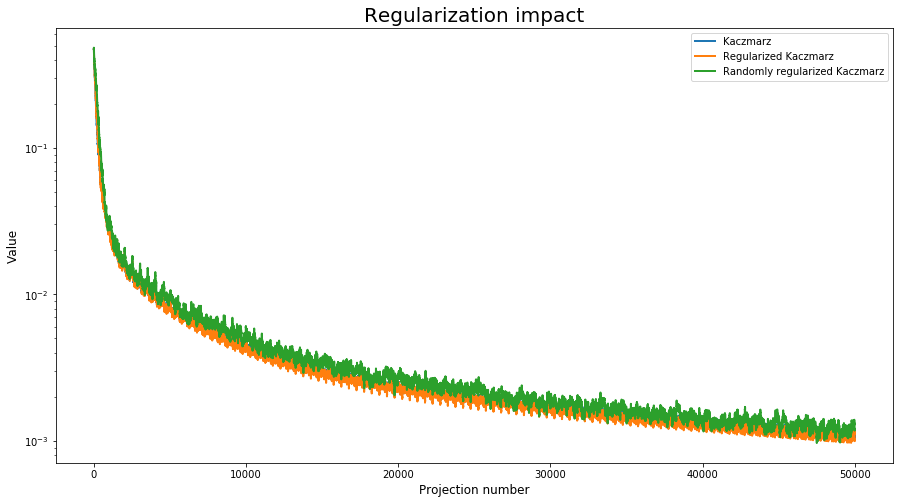

In [168]:
plt.figure(figsize=(15,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_RegCar, linestyle = '-', linewidth = 2.0, label='Regularized Kaczmarz')
plt.plot(res_RandRegCar, linestyle = '-', linewidth = 2.0, label='Randomly regularized Kaczmarz')
plt.title('Regularization impact', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

As we see, random regularization does not work properly in this case, but note that constant multiplier $\lambda = 1 + \frac{n}{m}$, where $A \in \mathbb{R}^{m \times n}, m \geq n$, is competitive, probably it should be tested with randomness.

In [174]:
eps = 1e-10
N_max = 50000
x_Car,res_Car,t_Car = RandomKaczmarz(A,values,x_0,N_max,eps,reg = 0)
x_RegCar,res_RegCar,t_RegCar = RandomKaczmarz(A,values,x_0,N_max,eps, reg = 1)
x_RandRegCar,res_RandRegCar,t_RandRegCar = RandomKaczmarz(A,values,x_0,N_max,eps, reg = 2)

no regularization
constant regularization
random regularization


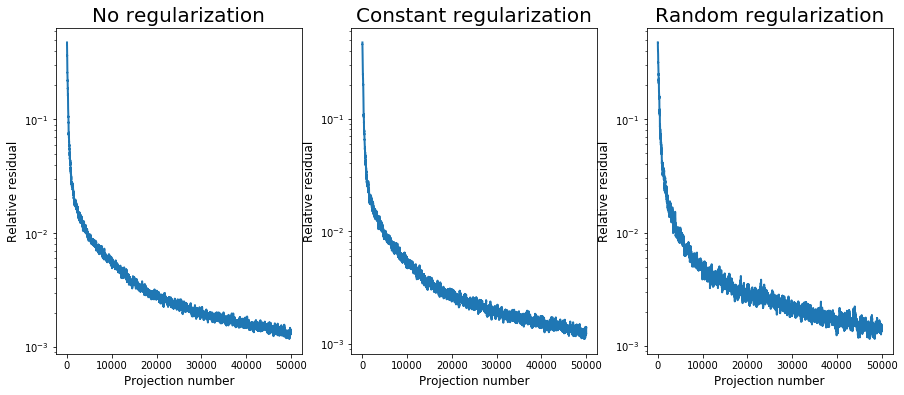

In [175]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.plot(res_Car, linestyle = '-', linewidth = 2.0)
plt.title('No regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.subplot(132)
plt.plot(res_RegCar, linestyle = '-', linewidth = 2.0, label='Regularized Kaczmarz')
plt.title('Constant regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.subplot(133)
plt.plot(res_RandRegCar, linestyle = '-', linewidth = 2.0, label='Randomly regularized Kaczmarz')
plt.title('Random regularization', fontsize = 20)
plt.ylabel('Relative residual', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.show()

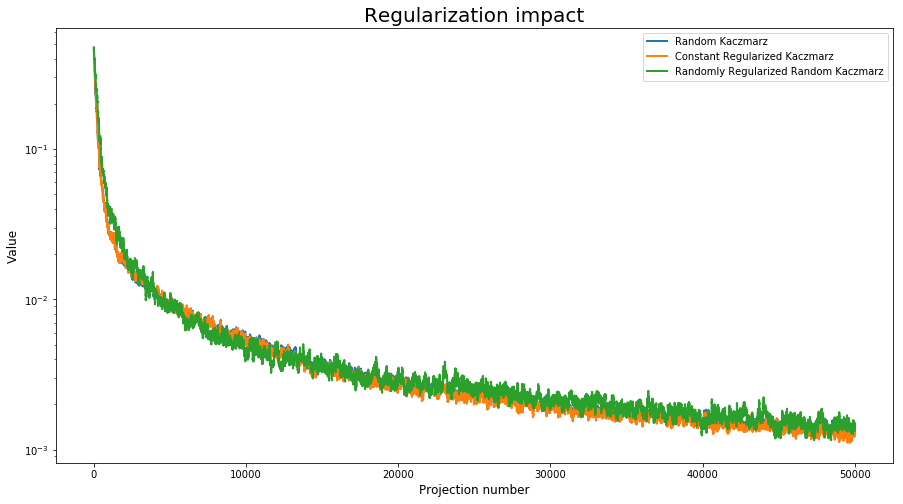

In [177]:
plt.figure(figsize=(15,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Random Kaczmarz')
plt.plot(res_RegCar, linestyle = '-', linewidth = 2.0, label='Constant Regularized Kaczmarz')
plt.plot(res_RandRegCar, linestyle = '-', linewidth = 2.0, label='Randomly Regularized Random Kaczmarz')
plt.title('Regularization impact', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Now compare methods on well-conditioned overdetermined matrix from Fourier transformation

In [182]:
#sample size
m = 700
r = 50
n = 2*r + 1
np.random.seed(666)
dots = np.random.rand(m)
sorted_dots = np.sort(dots)
true_coef = np.random.randn(n)
#we want Fourier coefficients to decrease as 1/n
for i in range(r):
    true_coef[r+i+1] = true_coef[r+i+1]/(i+1)
    true_coef[r-i-1] = true_coef[r-i-1]/(i+1)
#generate function values:
values = np.zeros(m,dtype=float)
omega = np.zeros(m,dtype = float)
omega[0] = np.sqrt(sorted_dots[1]-sorted_dots[0])
omega[m-1] = np.sqrt(sorted_dots[m-1]-sorted_dots[m-2])
for i in range(1,m-1):
    omega[i] = np.sqrt((sorted_dots[i+1]-sorted_dots[i-1])/2)
A = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        A[i,j] = np.cos(2*np.pi*(j-50)*sorted_dots[i])*omega[i]
        values[i] += true_coef[j]*np.cos(2*np.pi*(j-50)*sorted_dots[i])
    values[i] = values[i]*omega[i]
x_0 = np.random.rand(n)

Check regularization for such systems (well-conditioned)

In [183]:
eps = 1e-10
N_max = 50000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg = 0)
x_RegCar,res_RegCar,t_RegCar = Kaczmarz(A,values,x_0,N_max,eps, reg = 1)
x_RandRegCar,res_RandRegCar,t_RandRegCar = Kaczmarz(A,values,x_0,N_max,eps, reg = 2)

no regularization
constant regularization
random regularization


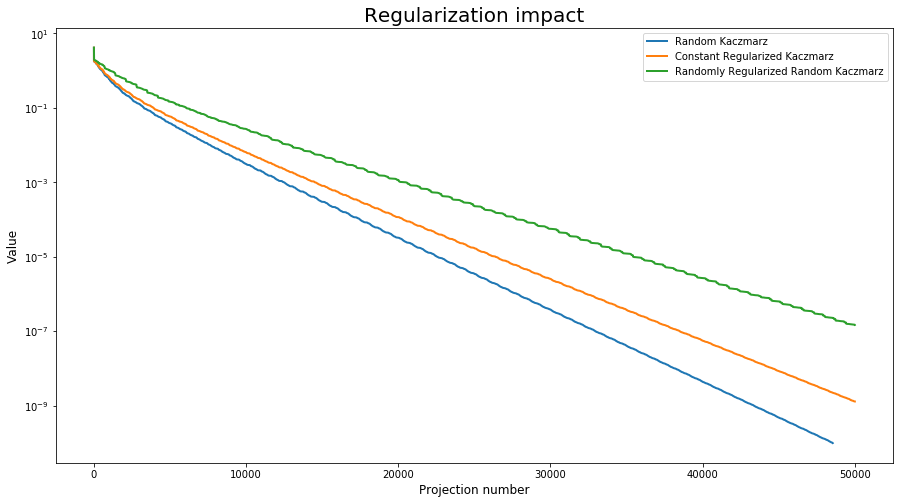

In [184]:
plt.figure(figsize=(15,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Random Kaczmarz')
plt.plot(res_RegCar, linestyle = '-', linewidth = 2.0, label='Constant Regularized Kaczmarz')
plt.plot(res_RandRegCar, linestyle = '-', linewidth = 2.0, label='Randomly Regularized Random Kaczmarz')
plt.title('Regularization impact', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Check Lyusternick Accelleration

no regularization
no regularization
accelerating; iterNum: 10501, q_last: 0.710699
disparity of x:  0.000719794753907
accelerating; iterNum: 15401, q_last: 0.700966
disparity of x:  2.49951405523e-05
accelerating; iterNum: 19601, q_last: 0.687278
disparity of x:  1.19212357967e-06
num_steps =  700
q_prev: 0.000667, q_last: 0.000546
q_prev: 0.000546, q_last: 0.000539


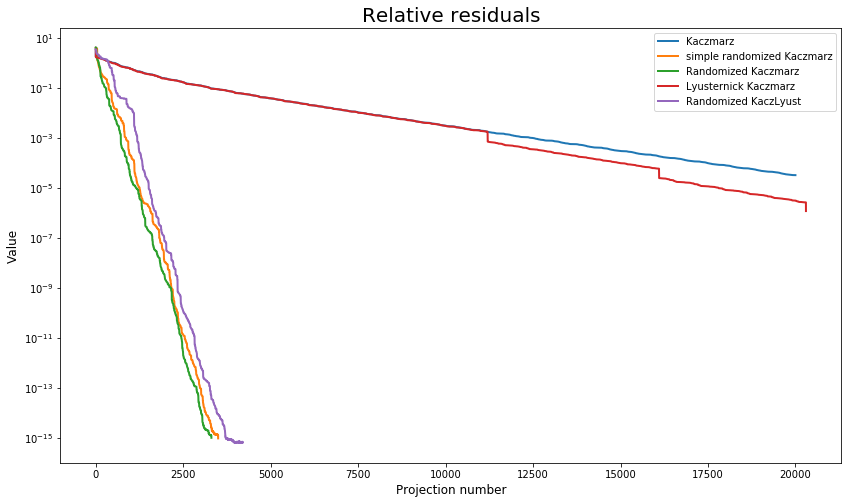

In [190]:
eps = 1e-15
N_max = 20000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg=0)
x_simple_rand,res_simple_rand,t_simple_rand = SimpleRandomKaczmarz(A,values,x_0,N_max,eps)
x_rand,res_rand,t_rand = RandomKaczmarz(A,values,x_0,N_max,eps,reg=0)
answer = calculate(A,values,eps,N_max,x_0)
answer_rand = RandomizedKaсzLust(A,values,eps,N_max,x_0)
plt.figure(figsize=(14,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_simple_rand, linestyle = '-', linewidth = 2.0, label='simple randomized Kaczmarz')
plt.plot(res_rand, linestyle = '-', linewidth = 2.0, label='Randomized Kaczmarz')
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Lyusternick Kaczmarz')
plt.plot(answer_rand['info']['res'], linestyle = '-', linewidth = 2.0, label='Randomized KaczLyust')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Thus, we may notice that on well-conditioned systems Lyusternick accelleration is not needed - it does not help to outperform randomized Kaczmacz. Also note that there are no hits in randomized KachLyust - descent is too quick. 

In [213]:
np.random.seed(666)
n = 500
m = 200
A = rand_for_given_cond_number(n,m, cond = 2)
true_vect = np.random.rand(m)
values = A @ true_vect
x_0 = np.random.rand(m)

sing_vals: [ 2.          1.99497487  1.98994975  1.98492462  1.9798995   1.97487437
  1.96984925  1.96482412  1.95979899  1.95477387  1.94974874  1.94472362
  1.93969849  1.93467337  1.92964824  1.92462312  1.91959799  1.91457286
  1.90954774  1.90452261  1.89949749  1.89447236  1.88944724  1.88442211
  1.87939698  1.87437186  1.86934673  1.86432161  1.85929648  1.85427136
  1.84924623  1.84422111  1.83919598  1.83417085  1.82914573  1.8241206
  1.81909548  1.81407035  1.80904523  1.8040201   1.79899497  1.79396985
  1.78894472  1.7839196   1.77889447  1.77386935  1.76884422  1.7638191
  1.75879397  1.75376884  1.74874372  1.74371859  1.73869347  1.73366834
  1.72864322  1.72361809  1.71859296  1.71356784  1.70854271  1.70351759
  1.69849246  1.69346734  1.68844221  1.68341709  1.67839196  1.67336683
  1.66834171  1.66331658  1.65829146  1.65326633  1.64824121  1.64321608
  1.63819095  1.63316583  1.6281407   1.62311558  1.61809045  1.61306533
  1.6080402   1.60301508  1.59798995  1.59

no regularization
no regularization


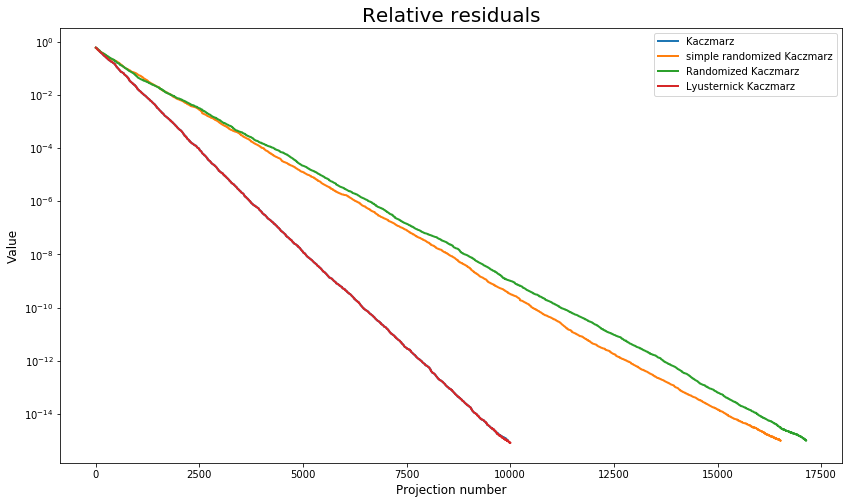

In [214]:
eps = 1e-15
N_max = 20000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg=0)
x_simple_rand,res_simple_rand,t_simple_rand = SimpleRandomKaczmarz(A,values,x_0,N_max,eps)
x_rand,res_rand,t_rand = RandomKaczmarz(A,values,x_0,N_max,eps,reg=0)
answer = calculate(A,values,eps,N_max,x_0)
#answer_rand = RandomizedKaсzLust(A,values,eps,N_max,x_0)
plt.figure(figsize=(14,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_simple_rand, linestyle = '-', linewidth = 2.0, label='simple randomized Kaczmarz')
plt.plot(res_rand, linestyle = '-', linewidth = 2.0, label='Randomized Kaczmarz')
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Lyusternick Kaczmarz')
#plt.plot(answer_rand['info']['res'], linestyle = '-', linewidth = 2.0, label='Randomized KaczLyust')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Let us check the case of ill-conditioned system now.

In [191]:
np.random.seed(666)
n = 500
m = 100
A = rand_for_given_cond_number(n,m, cond = 200)
true_vect = np.random.rand(m)
values = A @ true_vect
x_0 = np.random.rand(m)

sing_vals: [ 200.          197.98989899  195.97979798  193.96969697  191.95959596
  189.94949495  187.93939394  185.92929293  183.91919192  181.90909091
  179.8989899   177.88888889  175.87878788  173.86868687  171.85858586
  169.84848485  167.83838384  165.82828283  163.81818182  161.80808081
  159.7979798   157.78787879  155.77777778  153.76767677  151.75757576
  149.74747475  147.73737374  145.72727273  143.71717172  141.70707071
  139.6969697   137.68686869  135.67676768  133.66666667  131.65656566
  129.64646465  127.63636364  125.62626263  123.61616162  121.60606061
  119.5959596   117.58585859  115.57575758  113.56565657  111.55555556
  109.54545455  107.53535354  105.52525253  103.51515152  101.50505051
   99.49494949   97.48484848   95.47474747   93.46464646   91.45454545
   89.44444444   87.43434343   85.42424242   83.41414141   81.4040404
   79.39393939   77.38383838   75.37373737   73.36363636   71.35353535
   69.34343434   67.33333333   65.32323232   63.31313131   61.30303

no regularization
no regularization
accelerating; iterNum: 7501, q_last: 0.920507
disparity of x:  0.00300871448793
accelerating; iterNum: 13501, q_last: 0.964311
disparity of x:  0.00146634032883
accelerating; iterNum: 20001, q_last: 0.971808
disparity of x:  0.00092728575327
accelerating; iterNum: 27001, q_last: 0.971784
disparity of x:  0.000637849553314
accelerating; iterNum: 34001, q_last: 0.976571
disparity of x:  0.000507841476397
accelerating; iterNum: 41001, q_last: 0.973168
disparity of x:  0.000399792235912
accelerating; iterNum: 47501, q_last: 0.974472
disparity of x:  0.000352869445637


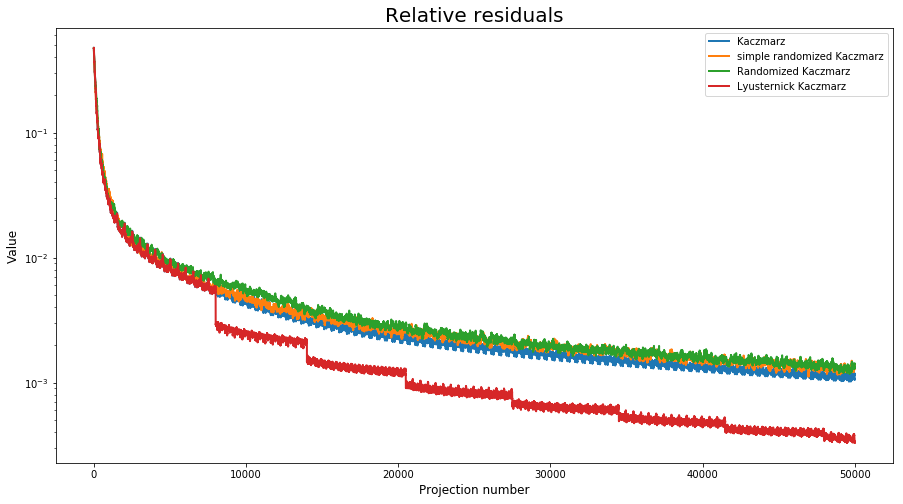

In [197]:
eps = 1e-10
N_max = 50000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg=0)
x_simple_rand,res_simple_rand,t_simple_rand = SimpleRandomKaczmarz(A,values,x_0,N_max,eps)
x_rand,res_rand,t_rand = RandomKaczmarz(A,values,x_0,N_max,eps,reg=0)
answer = calculate(A,values,eps,N_max,x_0)
#answer_rand = RandomizedKaсzLust(A,values,eps,N_max,x_0)
plt.figure(figsize=(15,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_simple_rand, linestyle = '-', linewidth = 2.0, label='simple randomized Kaczmarz')
plt.plot(res_rand, linestyle = '-', linewidth = 2.0, label='Randomized Kaczmarz')
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Lyusternick Kaczmarz')
#plt.plot(answer_rand['info']['res'], linestyle = '-', linewidth = 2.0, label='Randomized KaczLyust')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Thus, on systems with moderate condition number, Lyusternick accelleration is reasonable and outperforms results obtained with randomized version of the algorithm.

Now consider absolutely ill-conditioned system with $cond = 1e10$. In this case convergence rate of randomized Kaczmacz method is small enough, and Lyusternick accelleration outperforms it.

In [208]:
np.random.seed(666)
n = 500
m = 100
A = rand_for_given_cond_number(n,m, cond = 1e10)
true_vect = np.random.rand(m)
values = A @ true_vect
x_0 = np.random.rand(m)

sing_vals: [  1.00000000e+10   9.89898990e+09   9.79797980e+09   9.69696970e+09
   9.59595960e+09   9.49494950e+09   9.39393939e+09   9.29292929e+09
   9.19191919e+09   9.09090909e+09   8.98989899e+09   8.88888889e+09
   8.78787879e+09   8.68686869e+09   8.58585859e+09   8.48484848e+09
   8.38383838e+09   8.28282828e+09   8.18181818e+09   8.08080808e+09
   7.97979798e+09   7.87878788e+09   7.77777778e+09   7.67676768e+09
   7.57575758e+09   7.47474748e+09   7.37373737e+09   7.27272727e+09
   7.17171717e+09   7.07070707e+09   6.96969697e+09   6.86868687e+09
   6.76767677e+09   6.66666667e+09   6.56565657e+09   6.46464646e+09
   6.36363636e+09   6.26262626e+09   6.16161616e+09   6.06060606e+09
   5.95959596e+09   5.85858586e+09   5.75757576e+09   5.65656566e+09
   5.55555556e+09   5.45454546e+09   5.35353535e+09   5.25252525e+09
   5.15151515e+09   5.05050505e+09   4.94949495e+09   4.84848485e+09
   4.74747475e+09   4.64646465e+09   4.54545455e+09   4.44444444e+09
   4.34343434e+09   4.2

no regularization
no regularization
accelerating; iterNum: 7501, q_last: 0.924189
disparity of x:  0.00305831685609
accelerating; iterNum: 14001, q_last: 0.963849
disparity of x:  0.00152627368986
accelerating; iterNum: 20501, q_last: 0.975823
disparity of x:  0.000976801180004
accelerating; iterNum: 28001, q_last: 0.973539
disparity of x:  0.000675440725053
accelerating; iterNum: 35001, q_last: 0.976510
disparity of x:  0.000538210809725
accelerating; iterNum: 42001, q_last: 0.973520
disparity of x:  0.000442649997347
accelerating; iterNum: 48501, q_last: 0.975643
disparity of x:  0.000390659355138


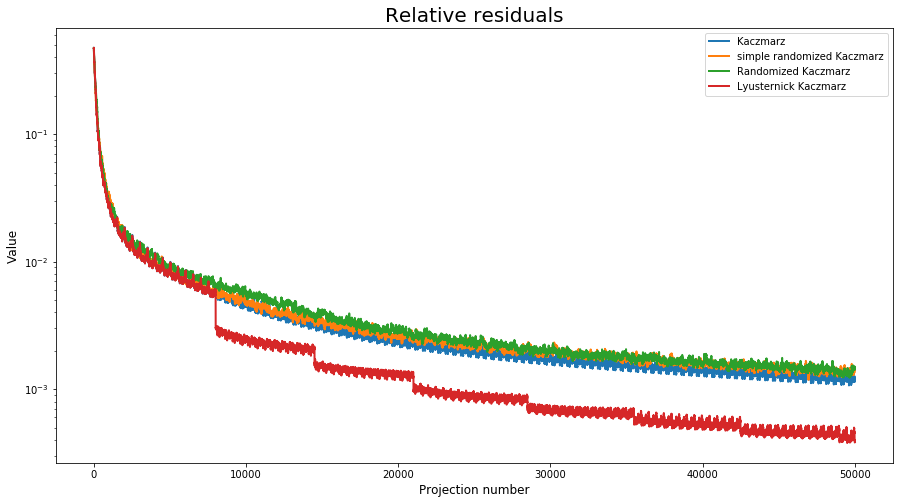

In [209]:
eps = 1e-10
N_max = 50000
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps,reg=0)
x_simple_rand,res_simple_rand,t_simple_rand = SimpleRandomKaczmarz(A,values,x_0,N_max,eps)
x_rand,res_rand,t_rand = RandomKaczmarz(A,values,x_0,N_max,eps,reg=0)
answer = calculate(A,values,eps,N_max,x_0)
#answer_rand = RandomizedKaсzLust(A,values,eps,N_max,x_0)
plt.figure(figsize=(15,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_simple_rand, linestyle = '-', linewidth = 2.0, label='simple randomized Kaczmarz')
plt.plot(res_rand, linestyle = '-', linewidth = 2.0, label='Randomized Kaczmarz')
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Lyusternick Kaczmarz')
#plt.plot(answer_rand['info']['res'], linestyle = '-', linewidth = 2.0, label='Randomized KaczLyust')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

Now consider case of ill-conditioned square matrix and add some noise.

In [222]:
np.random.seed(666)
n = 200
m = 200
A = rand_for_given_cond_number(n,m, cond = 1e10)
true_vect = np.random.rand(m)
values = A @ true_vect
err = np.random.randn(n)
values += err
x_0 = np.random.rand(m)

sing_vals: [  1.00000000e+10   9.94974874e+09   9.89949749e+09   9.84924623e+09
   9.79899497e+09   9.74874372e+09   9.69849246e+09   9.64824121e+09
   9.59798995e+09   9.54773869e+09   9.49748744e+09   9.44723618e+09
   9.39698492e+09   9.34673367e+09   9.29648241e+09   9.24623116e+09
   9.19597990e+09   9.14572864e+09   9.09547739e+09   9.04522613e+09
   8.99497487e+09   8.94472362e+09   8.89447236e+09   8.84422111e+09
   8.79396985e+09   8.74371859e+09   8.69346734e+09   8.64321608e+09
   8.59296482e+09   8.54271357e+09   8.49246231e+09   8.44221106e+09
   8.39195980e+09   8.34170854e+09   8.29145729e+09   8.24120603e+09
   8.19095477e+09   8.14070352e+09   8.09045226e+09   8.04020101e+09
   7.98994975e+09   7.93969849e+09   7.88944724e+09   7.83919598e+09
   7.78894472e+09   7.73869347e+09   7.68844221e+09   7.63819096e+09
   7.58793970e+09   7.53768844e+09   7.48743719e+09   7.43718593e+09
   7.38693467e+09   7.33668342e+09   7.28643216e+09   7.23618090e+09
   7.18592965e+09   7.1

accelerating; iterNum: 3001, q_last: 0.919361
disparity of x:  0.00845608901013
accelerating; iterNum: 5601, q_last: 0.959706
disparity of x:  0.00431072219751
accelerating; iterNum: 8401, q_last: 0.971807
disparity of x:  0.00319343260939
accelerating; iterNum: 11201, q_last: 0.973715
disparity of x:  0.0025970721275
accelerating; iterNum: 14001, q_last: 0.978570
disparity of x:  0.00216307547948
accelerating; iterNum: 17001, q_last: 0.975805
disparity of x:  0.00186438575206
accelerating; iterNum: 19801, q_last: 0.977003
disparity of x:  0.00160103827361
accelerating; iterNum: 22601, q_last: 0.973929
disparity of x:  0.00146493024207
accelerating; iterNum: 25201, q_last: 0.975083
disparity of x:  0.00130816026101
accelerating; iterNum: 28001, q_last: 0.976480
disparity of x:  0.00123923324247
accelerating; iterNum: 30801, q_last: 0.976834
disparity of x:  0.00112920879758
accelerating; iterNum: 33601, q_last: 0.975890
disparity of x:  0.00109564485158
accelerating; iterNum: 36401, q_

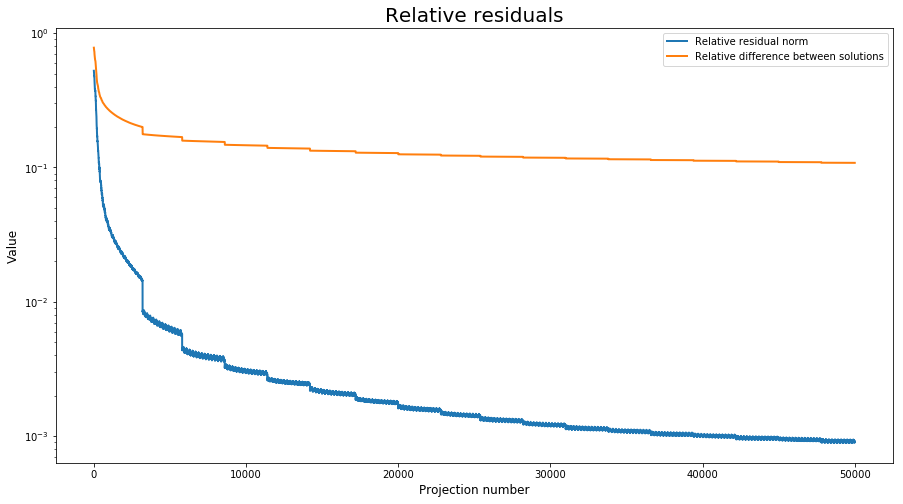

In [225]:
eps = 1e-10
N_max = 50000
answer = NewCalculate(A,values,eps,N_max,x_0,true_vect)
plt.figure(figsize=(15,8))
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Relative residual norm')
plt.plot(answer['info']['err'], linestyle = '-', linewidth = 2.0, label='Relative difference between solutions')
#plt.plot(answer_rand['info']['res'], linestyle = '-', linewidth = 2.0, label='Randomized KaczLyust')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

In [196]:
def calculate(A,b,eps,maxIter,x0):
    '''Performs the main calculation procedure over the params.
    calculate(dict params, int testNo=None) -> dict answer
    '''
    # You can print a debug info onto the main screen
    
    answer = {}
    answer['info'] = {'calcTime': None, 'iterNum': None, 'res': None}
    startTime = time.time()
    iterNum = 1
    
    n = len(A)
    A = A.astype(float); b = b.astype(float)    # required for division
    # Norm each equation
    normCoef = np.transpose(np.sqrt(np.sum(A ** 2, 1)))
    A /= normCoef[:,None]
    b /= normCoef
    # Choosing random x0
    random.seed(None)   # inits with cur time or some dif-t random val
    x = np.copy(x_0)
    # using 2nd norm below (change to suit your needs)
    disparity = lambda x: LA.norm(b - np.dot(A, np.transpose(x)))/LA.norm(b)
    cosVectAngle = lambda a, b: np.inner(a, b) / LA.norm(a) / LA.norm(b)
    HPlane_Pnts = deque()
    lastVr = None
    q_last = None
    init_lastVr = False
    answer['info']['res'] = [disparity(x)]
    while iterNum < maxIter and disparity(x) >= eps:
        for i in range(n):
            t = A[i] @ x - b[i]
            x -= A[i] * t
            new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
            answer['info']['res'].append(new_res)
            if i == n - 1:
                HPlane_Pnts.append(np.copy(x))
        if len(HPlane_Pnts) > 3:
            HPlane_Pnts.popleft()
            #pprint(HPlane_Pnts)
            if not init_lastVr:
                prevVr = HPlane_Pnts[-2] - HPlane_Pnts[-3]
            else:
                prevVr = lastVr
            lastVr = HPlane_Pnts[-1] - HPlane_Pnts[-2]
            init_lastVr = True
            #print 'cos(angle): ', cosVectAngle(prevVr, lastVr)
            #if np.isclose(cosVectAngle(prevVr, lastVr), 1):
            
            q_prev = q_last
            q_last = LA.norm(lastVr) / \
                    LA.norm(prevVr)
            #print 'q_prev: {}, q_last: {} '.format(q_prev, q_last)
            if not (q_prev is None) and \
                q_last != 1 and \
                np.isclose(q_prev, q_last, rtol = 1e-2) and \
                np.isclose(cosVectAngle(prevVr, lastVr), 1, rtol = 1e-3):
                
                # Lyusternik acceleration
                print('accelerating; iterNum: %d, q_last: %f' % (iterNum, q_last))
                x = HPlane_Pnts[-1] + (HPlane_Pnts[-1] - HPlane_Pnts[-2]) / (1.0 - q_last)
                print('disparity of x: ', disparity(x))
                HPlane_Pnts.clear()
                
            #time.sleep(2)
        iterNum += n
    #add last residual
    new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
    answer['info']['res'].append(new_res)
    #end
    endTime = time.time()
    answer['x'] = x
    answer['info']['calcTime'] = endTime - startTime
    answer['info']['iterNum'] = iterNum
    answer['info']['disparity'] = disparity(x)
    if A.shape[0] == A.shape[1]:
        answer['info']['conditionNum'] = LA.norm(A) * LA.norm(LA.inv(A))
    else:
        answer['info']['conditionNum'] = 0
    return answer

In [226]:
def NewCalculate(A,b,eps,maxIter,x0,x_exact):
    '''Performs the main calculation procedure over the params.
    calculate(dict params, int testNo=None) -> dict answer
    '''
    # You can print a debug info onto the main screen
    
    answer = {}
    answer['info'] = {'calcTime': None, 'iterNum': None, 'res': None,'err': None}
    startTime = time.time()
    iterNum = 1
    
    n = len(A)
    A = A.astype(float); b = b.astype(float)    # required for division
    # Norm each equation
    normCoef = np.transpose(np.sqrt(np.sum(A ** 2, 1)))
    A /= normCoef[:,None]
    b /= normCoef
    # Choosing random x0
    random.seed(None)   # inits with cur time or some dif-t random val
    x = np.copy(x_0)
    # using 2nd norm below (change to suit your needs)
    disparity = lambda x: LA.norm(b - np.dot(A, np.transpose(x)))/LA.norm(b)
    cosVectAngle = lambda a, b: np.inner(a, b) / LA.norm(a) / LA.norm(b)
    HPlane_Pnts = deque()
    lastVr = None
    q_last = None
    init_lastVr = False
    answer['info']['res'] = [disparity(x)]
    answer['info']['err'] = [np.linalg.norm(x - x_exact)/np.linalg.norm(x_exact)]
    while iterNum < maxIter and disparity(x) >= eps:
        for i in range(n):
            t = A[i] @ x - b[i]
            x -= A[i] * t
            new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
            answer['info']['res'].append(new_res)
            answer['info']['err'].append(np.linalg.norm(x - x_exact)/np.linalg.norm(x_exact))
            if i == n - 1:
                HPlane_Pnts.append(np.copy(x))
        if len(HPlane_Pnts) > 3:
            HPlane_Pnts.popleft()
            #pprint(HPlane_Pnts)
            if not init_lastVr:
                prevVr = HPlane_Pnts[-2] - HPlane_Pnts[-3]
            else:
                prevVr = lastVr
            lastVr = HPlane_Pnts[-1] - HPlane_Pnts[-2]
            init_lastVr = True
            #print 'cos(angle): ', cosVectAngle(prevVr, lastVr)
            #if np.isclose(cosVectAngle(prevVr, lastVr), 1):
            
            q_prev = q_last
            q_last = LA.norm(lastVr) / \
                    LA.norm(prevVr)
            #print 'q_prev: {}, q_last: {} '.format(q_prev, q_last)
            if not (q_prev is None) and \
                q_last != 1 and \
                np.isclose(q_prev, q_last, rtol = 1e-2) and \
                np.isclose(cosVectAngle(prevVr, lastVr), 1, rtol = 1e-3):
                
                # Lyusternik acceleration
                print('accelerating; iterNum: %d, q_last: %f' % (iterNum, q_last))
                x = HPlane_Pnts[-1] + (HPlane_Pnts[-1] - HPlane_Pnts[-2]) / (1.0 - q_last)
                print('disparity of x: ', disparity(x))
                HPlane_Pnts.clear()
                
            #time.sleep(2)
        iterNum += n
    #add last residual
    new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
    answer['info']['res'].append(new_res)
    #end
    endTime = time.time()
    answer['x'] = x
    answer['info']['calcTime'] = endTime - startTime
    answer['info']['iterNum'] = iterNum
    answer['info']['disparity'] = disparity(x)
    if A.shape[0] == A.shape[1]:
        answer['info']['conditionNum'] = LA.norm(A) * LA.norm(LA.inv(A))
    else:
        answer['info']['conditionNum'] = 0
    return answer

In [227]:
def RandomizedKaсzLust(A,b,eps,maxIter,x0):
    '''Performs the main calculation procedure over the params.
    calculate(dict params, int testNo=None) -> dict answer
    '''
    # You can print a debug info onto the main screen
    
    answer = {}
    answer['info'] = {'calcTime': None, 'iterNum': None, 'res': None}
    startTime = time.time()
    iterNum = 1
    
    n = len(A)
    num_steps = n
    print("num_steps = ",num_steps)
    A = A.astype(float); b = b.astype(float)    # required for division
    # Norm each equation
    normCoef = np.transpose(np.sqrt(np.sum(A ** 2, 1)))
    A /= normCoef[:,None]
    b /= normCoef
    # Choosing random x0
    random.seed(None)   # inits with cur time or some dif-t random val
    x = np.copy(x_0)
    # using 2nd norm below (change to suit your needs)
    disparity = lambda x: LA.norm(b - np.dot(A, np.transpose(x)))/LA.norm(b)
    cosVectAngle = lambda a, b: np.inner(a, b) / LA.norm(a) / LA.norm(b)
    HPlane_Pnts = deque()
    lastVr = None
    q_last = None
    init_lastVr = False
    answer['info']['res'] = [disparity(x)]
    while iterNum < maxIter and disparity(x) >= eps:
        for i in range(num_steps):
            k = np.random.randint(n)
            t = A[k] @ x - b[k]
            x -= A[k] * t
            new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
            answer['info']['res'].append(new_res)
            if i == num_steps - 1:
                HPlane_Pnts.append(np.copy(x))
        if len(HPlane_Pnts) > 3:
            HPlane_Pnts.popleft()
            #pprint(HPlane_Pnts)
            if not init_lastVr:
                prevVr = HPlane_Pnts[-2] - HPlane_Pnts[-3]
            else:
                prevVr = lastVr
            lastVr = HPlane_Pnts[-1] - HPlane_Pnts[-2]
            init_lastVr = True
            #print 'cos(angle): ', cosVectAngle(prevVr, lastVr)
            #if np.isclose(cosVectAngle(prevVr, lastVr), 1):
            
            q_prev = q_last
            q_last = LA.norm(lastVr) / \
                    LA.norm(prevVr)
            if not (q_prev is None):
                print('q_prev: %f, q_last: %f' % (q_prev, q_last))
            if not (q_prev is None) and \
                q_last != 1 and \
                np.isclose(q_prev, q_last, rtol = 1e-2) and \
                np.isclose(cosVectAngle(prevVr, lastVr), 1, rtol = 1e-3):
                
                # Lyusternik acceleration
                print('accelerating; iterNum: %d, q_last: %f' % (iterNum, q_last))
                x = HPlane_Pnts[-1] + (HPlane_Pnts[-1] - HPlane_Pnts[-2]) / (1.0 - q_last)
                print('disparity of x: ', disparity(x))
                HPlane_Pnts.clear()
                
            #time.sleep(2)
        iterNum += num_steps
    #add last residual
    new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
    answer['info']['res'].append(new_res)
    #end
    endTime = time.time()
    answer['x'] = x
    answer['info']['calcTime'] = endTime - startTime
    answer['info']['iterNum'] = iterNum
    answer['info']['disparity'] = disparity(x)
    if A.shape[0] == A.shape[1]:
        answer['info']['conditionNum'] = LA.norm(A) * LA.norm(LA.inv(A))
    else:
        answer['info']['conditionNum'] = 0
    return answer